<a href="https://colab.research.google.com/github/minseong-oh/TransformerForTranslation/blob/main/Translator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [2]:
%%capture
!pip install gdown
!pip install transformers
!pip install einops # Einstein operations => rearrange 함수를 위해

In [3]:
from google.colab import drive
drive.mount('/content/drive')
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from transformers import MarianMTModel, MarianTokenizer
import pandas as pd
from tqdm import tqdm
import math
import random
from einops import rearrange
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

Mounted at /content/drive
cuda


In [4]:
# for random seed
random_seed = 0
torch.manual_seed(random_seed) #torch에서 동일한 seed를 설정
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(random_seed)

### Load the tokenizer

In [5]:
tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-ko-en")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/842k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/813k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [6]:
eos_idx = tokenizer.eos_token_id
pad_idx = tokenizer.pad_token_id
print("eos_idx = ", eos_idx)
print("pad_idx = ", pad_idx)

eos_idx =  0
pad_idx =  65000


In [7]:
BATCH_SIZE = 64
LAMBDA = 0
EPOCH = 15
max_len = 100
criterion = nn.CrossEntropyLoss(ignore_index = pad_idx) # pad token 시점에서의 loss 무시

scheduler_name = 'Noam'

warmup_steps = 1000
LR_scale = 0.5

save_model_path = '/content/drive/MyDrive/Colab Notebooks/results/Transformer_small2.pt'
save_history_path = '/content/drive/MyDrive/Colab Notebooks/results/Transformer_small2_history.pt'

In [8]:
# 논문보다 모델 사이즈 축소
n_layers = 3
d_model = 256
d_ff = 512
n_heads = 8
drop_p = 0.1

In [9]:
vocab_size = tokenizer.vocab_size

In [10]:
!gdown https://drive.google.com/uc?id=1Yvsp6Nv4VUWEg0qOVU2TVFwYOXoKUJgm
data = pd.read_excel('대화체.xlsx')

Downloading...
From: https://drive.google.com/uc?id=1Yvsp6Nv4VUWEg0qOVU2TVFwYOXoKUJgm
To: /content/대화체.xlsx
100% 8.17M/8.17M [00:01<00:00, 7.57MB/s]


In [11]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data.loc[idx, '원문'], self.data.loc[idx, '번역문']

custom_DS = CustomDataset(data)

train_DS, val_DS, test_DS = torch.utils.data.random_split(custom_DS, [97000,2000,1000])

train_DL = torch.utils.data.DataLoader(train_DS, batch_size = BATCH_SIZE, shuffle = True)
val_DL = torch.utils.data.DataLoader(val_DS, batch_size = BATCH_SIZE, shuffle = True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size = BATCH_SIZE, shuffle = True)

print(len(train_DS))
print(len(val_DS))
print(len(test_DS))

97000
2000
1000


## Transformer 모델 구현

### Multi-Head Attention



In [12]:
class MHA(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()

        self.n_heads = n_heads

        self.fc_q = nn.Linear(d_model, d_model)
        self.fc_k = nn.Linear(d_model, d_model)
        self.fc_v = nn.Linear(d_model, d_model)
        self.fc_o = nn.Linear(d_model, d_model)

        self.scale = torch.sqrt(torch.tensor(d_model/n_heads))

    def forward(self, q, k, v, mask=None):
        batch_size = q.shape[0]

        q = self.fc_q(q)
        k = self.fc_k(k)
        v = self.fc_v(v)

        q = rearrange(q, 'b n (h d) -> b h n d', h = self.n_heads)
        k = rearrange(k, 'b n (h d) -> b h n d', h = self.n_heads)
        v = rearrange(v, 'b n (h d) -> b h n d', h = self.n_heads)

        # Attention
        attention_score = q @ k.transpose(-1, -2) / self.scale

        if mask is not None:
            attention_score[mask] = -1e10

        attention_score = torch.softmax(attention_score, dim = -1)
        attention = attention_score @ v
        attention = rearrange(attention, 'b h n d -> b n (h d)') # (64,3,512)
        output = self.fc_o(attention) # nn.Linear(512,512) 통과

        return output

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, drop_p):
        super().__init__()

        self.fc = nn.Sequential(nn.Linear(d_model, d_ff), # 비선형성을 위한 늘렸다 줄이기
                                nn.ReLU(),
                                nn.Dropout(drop_p),
                                nn.Linear(d_ff, d_model))
    def forward(self, x):
        output = self.fc(x)
        return output

### Encoder

In [13]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, d_ff, n_heads, drop_p):
        super().__init__()

        self.self_atten = MHA(d_model, n_heads)
        self.self_atten_LN = nn.LayerNorm(d_model)

        self.FF = FeedForward(d_model, d_ff, drop_p)
        self.FF_LN = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(drop_p)

    def forward(self, x, enc_mask):
        residual = self.self_atten(x, x, x, enc_mask)
        residual = self.dropout(residual)
        x = self.self_atten_LN(x + residual)

        residual = self.FF(x)
        residual = self.dropout(residual)
        x = self.FF_LN(x + residual)

        return x

class Encoder(nn.Module):
    def __init__(self, input_embedding, max_len, n_layers, d_model, d_ff, n_heads, drop_p):
        super().__init__()
        self.scale = torch.sqrt(torch.tensor(d_model))
        self.input_embedding = input_embedding
        self.pos_embedding = nn.Embedding(max_len, d_model)

        self.dropout = nn.Dropout(drop_p)

        self.layers = nn.ModuleList([EncoderLayer(d_model, d_ff, n_heads, drop_p) for _ in range(n_layers)])

    def forward(self, src, mask):
        pos = torch.arange(src.shape[1]).expand_as(src).to(DEVICE)
        x = self.scale * self.input_embedding(src) + self.pos_embedding(pos)
        x = self.dropout(x)

        for layer in self.layers:
            x = layer(x, mask)

        return x

### Decoder

In [14]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, d_ff, n_heads, drop_p):
        super().__init__()

        self.self_atten = MHA(d_model, n_heads)
        self.self_atten_LN = nn.LayerNorm(d_model)

        self.enc_dec_atten = MHA(d_model, n_heads)
        self.enc_dec_atten_LN = nn.LayerNorm(d_model)

        self.FF = FeedForward(d_model, d_ff, drop_p)
        self.FF_LN = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(drop_p)

    def forward(self, x, enc_out, dec_mask, enc_dec_mask):
        residual = self.self_atten(x, x, x, dec_mask)
        residual = self.dropout(residual)
        x = self.self_atten_LN(x+residual)

        residual = self.enc_dec_atten(x, enc_out, enc_out, enc_dec_mask)
        residual = self.dropout(residual)
        x = self.enc_dec_atten_LN(x+residual)

        residual = self.FF(x)
        residual = self.dropout(residual)
        x = self.FF_LN(x + residual)

        return x

class Decoder(nn.Module):
    def __init__(self, input_embedding, max_len, n_layers, d_model, d_ff, n_heads, drop_p):
        super().__init__()

        self.scale = torch.sqrt(torch.tensor(d_model))
        self.input_embedding = input_embedding
        self.pos_embedding = nn.Embedding(max_len, d_model)

        self.dropout = nn.Dropout(drop_p)

        self.layers = nn.ModuleList([DecoderLayer(d_model, d_ff, n_heads, drop_p) for _ in range(n_layers)])
        # 윗부분은 Encoder와 동일

        self.fc_out = nn.Linear(d_model, vocab_size) # 최종 Linear. 파라미터 많이 쓰이는 곳.

    def forward(self, trg, enc_out, dec_mask, enc_dec_mask, atten_map_save=False):
        pos = torch.arange(trg.shape[1]).expand_as(trg).to(DEVICE)
        x = self.scale*self.input_embedding(trg) + self.pos_embedding(pos)
        x = self.dropout(x)

        for layer in self.layers:
            x = layer(x, enc_out, dec_mask, enc_dec_mask)
        x = self.fc_out(x)
        return x

### Transformer

In [15]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, max_len, n_layers, d_model, d_ff, n_heads, drop_p):
        super().__init__()

        self.input_embedding = nn.Embedding(vocab_size, d_model)
        self.encoder = Encoder(self.input_embedding, max_len, n_layers, d_model, d_ff, n_heads, drop_p)
        self.decoder = Decoder(self.input_embedding, max_len, n_layers, d_model, d_ff, n_heads, drop_p)

        self.n_heads = n_heads

        for m in self.modules():
            if hasattr(m,'weight') and m.weight.dim() > 1:
                nn.init.xavier_uniform_(m.weight)

    def make_enc_mask(self, src):
        enc_mask = (src == pad_idx).unsqueeze(1).unsqueeze(2) # pad token mask
        enc_mask = enc_mask.expand(src.shape[0], self.n_heads, src.shape[1], src.shape[1]) # batch, head, src_len, src_len
        return enc_mask

    def make_dec_mask(self, trg):

        trg_pad_mask = (trg == pad_idx).unsqueeze(1).unsqueeze(2)
        trg_pad_mask = trg_pad_mask.expand(trg.shape[0], self.n_heads, trg.shape[1], trg.shape[1])

        trg_future_mask = torch.tril(torch.ones(trg.shape[0], self.n_heads, trg.shape[1], trg.shape[1]))==0
        trg_future_mask = trg_future_mask.to(DEVICE)

        dec_mask = trg_pad_mask | trg_future_mask

        return dec_mask

    def make_enc_dec_mask(self, src, trg):
        enc_dec_mask = (src == pad_idx).unsqueeze(1).unsqueeze(2)
        enc_dec_mask = enc_dec_mask.expand(trg.shape[0], self.n_heads, trg.shape[1], src.shape[1])

        return enc_dec_mask

    def forward(self, src, trg):
        enc_mask = self.make_enc_mask(src)
        dec_mask = self.make_dec_mask(trg)
        enc_dec_mask = self.make_enc_dec_mask(src, trg)

        enc_out = self.encoder(src, enc_mask)
        dec_out = self.decoder(trg, enc_out, dec_mask, enc_dec_mask)

        return dec_out

In [16]:
tensor = torch.tensor([1, 2, 3])
print(tensor.shape)  # 출력: torch.Size([3])
print(tensor)

tensor_unsqueezed = tensor.unsqueeze(0)
print(tensor_unsqueezed.shape)  # 출력: torch.Size([1, 3])
print(tensor_unsqueezed)

tensor_unsqueezed = tensor.unsqueeze(1)
print(tensor_unsqueezed.shape)  # 출력: torch.Size([3, 1])
print(tensor_unsqueezed)


torch.Size([3])
tensor([1, 2, 3])
torch.Size([1, 3])
tensor([[1, 2, 3]])
torch.Size([3, 1])
tensor([[1],
        [2],
        [3]])


### model test

In [17]:
model = Transformer(vocab_size, max_len, n_layers, d_model, d_ff, n_heads, drop_p).to(DEVICE)

src = torch.tensor([[4,6,5,1,1,1],[7,7,1,1,1,1]]).to(DEVICE)
trg = torch.tensor([[2,5,4,4,3,1,1],[2,9,6,7,3,1,1]]).to(DEVICE)

model.eval()
with torch.no_grad():
    x = model(src, trg)[0]
print(trg.shape)
print(x.shape)

torch.Size([2, 7])
torch.Size([7, 65001])


### Train, Test, loss_epoch

In [19]:
def Train(model, train_DL, val_DL, criterion, optimizer, scheduler = None):
    loss_history = {"train":[], "val":[]}
    best_loss = 9999
    for ep in range(EPOCH):
        model.train()
        train_loss = loss_epoch(model, train_DL, criterion, optimizer=optimizer, scheduler=scheduler)
        loss_history["train"].append(train_loss)

        model.eval()
        with torch.no_grad():
            val_loss = loss_epoch(model, val_DL, criterion)
            loss_history['val'].append(val_loss)

            if val_loss < best_loss:
                best_loss = val_loss
                torch.save({"model": model,
                            "ep": ep,
                            "optimizer": optimizer,
                            "scheduler": scheduler,}, save_model_path)

        print(f"Epoch {ep+1}: train loss: {train_loss:.5f}   val loss: {val_loss:.5f}   current_LR: {optimizer.param_groups[0]['lr']:.8f}")
        print("-" * 20)

    torch.save({"loss_history": loss_history,
                "EPOCH": EPOCH,
                "BATCH_SIZE": BATCH_SIZE}, save_history_path)

def Test(model, test_DL, criterion):
    model.eval()
    with torch.no_grad():
        test_loss = loss_epoch(model, test_DL, criterion)
    print(f"Test loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):.3f}")

def loss_epoch(model, DL, criterion, optimizer = None, scheduler = None):
    N = len(DL.dataset)

    rloss=0
    for src_texts, trg_texts in tqdm(DL, leave=False):
        src = tokenizer(src_texts, padding=True, truncation=True, max_length = max_len, return_tensors='pt', add_special_tokens = False).input_ids.to(DEVICE)
        trg_texts = ['</s> ' + s for s in trg_texts]
        trg = tokenizer(trg_texts, padding=True, truncation=True, max_length = max_len, return_tensors='pt').input_ids.to(DEVICE)
        y_hat = model(src, trg[:,:-1])
        loss = criterion(y_hat.permute(0,2,1), trg[:,1:])

        # update
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if scheduler is not None:
            scheduler.step()

        # loss accumulation
        loss_b = loss.item() * src.shape[0]
        rloss += loss_b
    loss_e = rloss/N
    return loss_e

### NoamScheduler




In [20]:
class NoamScheduler:
    def __init__(self, optimizer, d_model, warmup_steps, LR_scale = 1):
        self.optimizer = optimizer
        self.current_step = 0
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.LR_scale = LR_scale

    def step(self):
        self.current_step += 1
        lrate = self.LR_scale * (self.d_model ** -0.5) * min(self.current_step ** -0.5, self.current_step * self.warmup_steps ** -1.5)
        self.optimizer.param_groups[0]['lr'] = lrate

### Model Traininig

In [21]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=0,
                        betas=(0.9, 0.98), eps=1e-9,
                        weight_decay=LAMBDA)
scheduler = NoamScheduler(optimizer, d_model=d_model, warmup_steps=warmup_steps, LR_scale=LR_scale)

Train(model, train_DL, val_DL, criterion, optimizer, scheduler)

Epoch 1: train loss: 3.79943   val loss: 2.32098   current_LR: 0.00080260
--------------------


Epoch 2: train loss: 2.16062   val loss: 1.88845   current_LR: 0.00056753
--------------------


Epoch 3: train loss: 1.79072   val loss: 1.65564   current_LR: 0.00046338
--------------------


Epoch 4: train loss: 1.59849   val loss: 1.55379   current_LR: 0.00040130
--------------------


Epoch 5: train loss: 1.47909   val loss: 1.48467   current_LR: 0.00035893
--------------------


Epoch 6: train loss: 1.39317   val loss: 1.44003   current_LR: 0.00032766
--------------------


Epoch 7: train loss: 1.32608   val loss: 1.41820   current_LR: 0.00030336
--------------------


Epoch 8: train loss: 1.27152   val loss: 1.39396   current_LR: 0.00028376
--------------------


Epoch 9: train loss: 1.22538   val loss: 1.37700   current_LR: 0.00026753
--------------------


Epoch 10: train loss: 1.18463   val loss: 1.36414   current_LR: 0.00025381
--------------------


Epoch 11: train loss: 1.15054   val loss: 1.35429   current_LR: 0.00024199
--------------------


Epoch 12: train loss: 1.11901   val loss: 1.35165   current_LR: 0.00023169
--------------------


Epoch 13: train loss: 1.08955   val loss: 1.34505   current_LR: 0.00022260
--------------------


Epoch 14: train loss: 1.06466   val loss: 1.34179   current_LR: 0.00021450
--------------------


Epoch 15: train loss: 1.04165   val loss: 1.34365   current_LR: 0.00020723
--------------------


### Model Load

In [22]:
loaded = torch.load(save_model_path, map_location=DEVICE)
load_model = loaded["model"]
ep = loaded["ep"]
optimizer = loaded["optimizer"]

loaded = torch.load(save_history_path, map_location=DEVICE)
loss_history = loaded["loss_history"]

print(ep)
print(optimizer)

<ipython-input-22-c96f6b8a1623>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded = torch.load(save_model_path, map_location=DEVICE)


13
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.98)
    capturable: False
    differentiable: False
    eps: 1e-09
    foreach: None
    fused: None
    lr: 0.00021450449787356664
    maximize: False
    weight_decay: 0
)


<ipython-input-22-c96f6b8a1623>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded = torch.load(save_history_path, map_location=DEVICE)


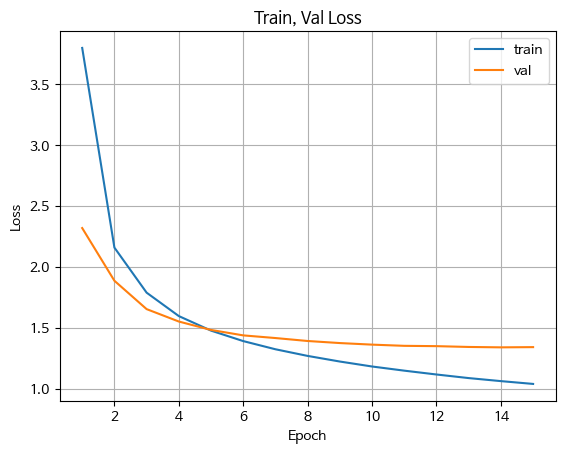

In [23]:
plt.figure()
plt.plot(range(1,EPOCH+1),loss_history["train"], label="train")
plt.plot(range(1,EPOCH+1),loss_history["val"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train, Val Loss")
plt.grid()
plt.legend()